### 1. Data source: SoC EIS LFP dataset

For this notebook I use the public dataset:

> Mustafa, Hamza; Bourelly, Carmine; Vitelli, Michele; Milano, Fillippo; Molinara, Mario; Ferrigno, Luigi (2024),  
> **“SoC Estimation on Li-ion Batteries: A New EIS-based Dataset for data-driven applications”**,  
> Mendeley Data, V2, doi: 10.17632/cb887gkmxw.2.  
> Available at: https://data.mendeley.com/datasets/cb887gkmxw/2  
> License: **CC BY 4.0**

Dataset highlights:

- 11 cylindrical **LFP** cells (B01–B11).
- EIS at 19 SoC levels: 100%, 95%, 90%, 85%, 80%, 75%, 70%, 65%, 60%, 55%, 50%, 45%, 35%, 30%, 25%, 20%, 15%, 10%, 5%.
- Two discharge cycles per cell, same frequency grid from 0.01 Hz to 1000 Hz (28 frequencies).

Folder structure (after downloading the dataset into `../data/soc_eis_lfp/`):

- One folder per cell: `B01`, `B02`, ..., `B11`.
- Inside each `Bxx` folder:
  - `EIS Measurement/` — subfolders with the actual EIS CSV files.
  - `Capacity Measurement/` — capacity test CSV (not used in this first notebook).


### 2. Load data & quick sanity checks.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_ROOT = Path("../data/soc_eis_lfp")

COLUMN_MAP = {
    "Frequency(Hz)": "frequency_hz",
    "R(ohm)": "z_real_ohm",
    "X(ohm)": "z_imag_ohm",
    "T(deg C)": "temperature_c",
}

def load_soc_eis(data_root: Path) -> pd.DataFrame:
    records = []

    for batt in range(1, 12):  # B01 .. B11
        battery_id = f"B{batt:02d}"

        for test_name, cycle in [("Test_1", 1), ("Test_2", 2)]:
            hioki_dir = data_root / battery_id / "EIS measurements" / test_name / "Hioki"

            for csv_path in sorted(hioki_dir.glob("*.csv")):
                # Hk_IFR14500_SoC_100_03-07-2023_11-46.csv -> SoC = 100
                fname_parts = csv_path.stem.split("_")
                soc = int(fname_parts[3])

                df_raw = pd.read_csv(csv_path)
                df = df_raw[list(COLUMN_MAP.keys())].rename(columns=COLUMN_MAP)

                df["battery_id"] = battery_id
                df["cycle"] = cycle
                df["soc"] = soc

                records.append(df)

    full_df = pd.concat(records, ignore_index=True)
    return full_df

eis_df = load_soc_eis(DATA_ROOT)

# Quick sanity checks
print("Shape:", eis_df.shape)
print("Batteries:", eis_df["battery_id"].unique())
print("Cycles:", sorted(eis_df["cycle"].unique()))
print("Unique SOCs:", sorted(eis_df["soc"].unique()))
print("Freq min/max:", eis_df["frequency_hz"].min(), "→", eis_df["frequency_hz"].max())
print("Temp min/max:", eis_df["temperature_c"].min(), "→", eis_df["temperature_c"].max())

eis_df.head()


Shape: (12320, 7)
Batteries: ['B01' 'B02' 'B03' 'B04' 'B05' 'B06' 'B07' 'B08' 'B09' 'B10' 'B11']
Cycles: [np.int64(1), np.int64(2)]
Unique SOCs: [np.int64(5), np.int64(10), np.int64(15), np.int64(20), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50), np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(95), np.int64(100)]
Freq min/max: 0.01 → 1000.0
Temp min/max: 20 → 20


,frequency_hz,z_real_ohm,z_imag_ohm,temperature_c,battery_id,cycle,soc
0,0.01,0.227844,-0.313990,20,B01,1,100
1,0.02,0.182858,-0.197273,20,B01,1,100
2,0.03,0.163270,-0.160068,20,B01,1,100
3,0.05,0.138709,-0.113159,20,B01,1,100
4,0.08,0.121685,-0.082724,20,B01,1,100


In [2]:
# Basic overview
eis_df.describe(include="all").round(3)


,frequency_hz,z_real_ohm,z_imag_ohm,temperature_c,battery_id,cycle,soc
count,12320.000,12320.000,12320.000,12320.0,12320,12320.0,12320.000
unique,NaN,NaN,NaN,NaN,11,NaN,NaN
top,NaN,NaN,NaN,NaN,B01,NaN,NaN
freq,NaN,NaN,NaN,NaN,1120,NaN,NaN
mean,117.360,0.078,-0.015,20.0,NaN,1.5,52.500
std,246.764,0.025,0.031,0.0,NaN,0.5,28.833
min,0.010,0.042,-1.329,20.0,NaN,1.0,5.000
25%,0.275,0.061,-0.015,20.0,NaN,1.0,28.750
50%,6.500,0.072,-0.007,20.0,NaN,1.5,52.500
75%,85.750,0.089,-0.006,20.0,NaN,2.0,76.250


In [3]:
# 1) Missing values
eis_df.isna().sum()


frequency_hz     0
z_real_ohm       0
z_imag_ohm       0
temperature_c    0
battery_id       0
cycle            0
soc              0
dtype: int64

In [4]:
# 2) Duplicate rows
eis_df.duplicated().sum()


np.int64(0)

In [5]:
# 3) Per-spectrum point count
pts_per_spectrum = (
    eis_df
    .groupby(["battery_id", "cycle", "soc"])["frequency_hz"]
    .count()
)

print("Unique point counts per spectrum:", pts_per_spectrum.unique())
pts_per_spectrum.describe()


Unique point counts per spectrum: [28]


count    440.0
mean      28.0
std        0.0
min       28.0
25%       28.0
50%       28.0
75%       28.0
max       28.0
Name: frequency_hz, dtype: float64

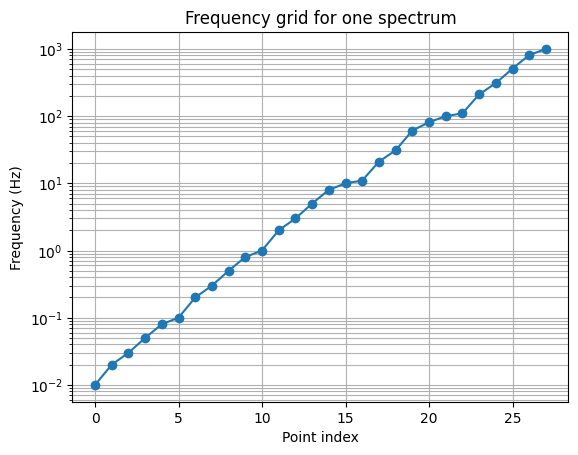

In [6]:
import matplotlib.pyplot as plt

spec = (
    eis_df
    .query("battery_id == 'B01' and cycle == 1 and soc == 50")
    .sort_values("frequency_hz")
)

spec = spec.reset_index(drop=True)

plt.figure()
spec["frequency_hz"].plot(marker="o")
plt.yscale("log")
plt.xlabel("Point index")
plt.ylabel("Frequency (Hz)")
plt.title("Frequency grid for one spectrum")
plt.grid(True, which="both")
plt.show()
